In [ ]:
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('../../data/processed/sleep_cycle_productivity_cleaned.csv')
df.head(5)

,Date,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level,Weekday
0,2024-04-12,30,2,23.33,4.61,5.28,3,86,116,8.808920,8,3,6,Friday
1,2024-11-04,40,0,21.02,2.43,5.41,5,32,88,6.329833,10,3,7,Monday
2,2024-08-31,20,1,22.10,3.45,5.35,7,17,59,8.506306,10,9,10,Saturday
3,2024-02-22,30,2,23.10,6.65,7.55,8,46,80,6.070240,8,4,2,Thursday
4,2024-02-23,40,2,21.42,4.17,6.75,10,61,94,11.374994,8,7,9,Friday


In [4]:
# 연속형 -> 순서형 
ordered_score = CategoricalDtype(categories=list(range(1, 11)), ordered=True)

# 적용
df['Sleep Quality'] = df['Sleep Quality'].astype(ordered_score)
df['Productivity Score'] = df['Productivity Score'].astype(ordered_score)
df['Mood Score'] = df['Mood Score'].astype(ordered_score)
df['Stress Level'] = df['Stress Level'].astype(ordered_score)

#범주형 변환 
df['Gender'] = df['Gender'].astype('category')
df['Weekday'] = df['Weekday'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Date                           5000 non-null   object  
 1   Age                            5000 non-null   int64   
 2   Gender                         5000 non-null   category
 3   Sleep Start Time               5000 non-null   float64 
 4   Sleep End Time                 5000 non-null   float64 
 5   Total Sleep Hours              5000 non-null   float64 
 6   Sleep Quality                  5000 non-null   category
 7   Exercise (mins/day)            5000 non-null   int64   
 8   Screen Time Before Bed (mins)  5000 non-null   int64   
 9   Work Hours (hrs/day)           5000 non-null   float64 
 10  Productivity Score             5000 non-null   category
 11  Mood Score                     5000 non-null   category
 12  Stress Level                   500

In [6]:
df['Weekday'] = df['Weekday'].cat.codes

In [7]:
# 종속변수 이진분류: Sleep Quality 5 이상이면 1, 아니면 0
df['Sleep_Quality_Binary'] = (df['Sleep Quality'] >= 5).astype(int)
y = df['Sleep_Quality_Binary']

X = df[['Age', 'Gender', 'Sleep Start Time', 'Sleep End Time',
        'Total Sleep Hours', 'Exercise (mins/day)',
        'Screen Time Before Bed (mins)', 'Work Hours (hrs/day)',
        'Productivity Score', 'Mood Score', 'Stress Level', 'Weekday']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#전체모형 
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

전체모형과 축소모형 모두 동일한 트리 구조 제한 조건 (max_depth=5, min_samples_split=30, max_leaf_nodes=10) 하에 학습하여 비교하였으며, 이에 따라 트리 구조의 복잡도 차이를 제거하고 변수 구성에 따른 모델 성능만을 비교하였다.

In [9]:
tree_full = tree.DecisionTreeClassifier(
    max_depth =5,min_samples_split=30, max_leaf_nodes =10,random_state=0)
tree_full.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, min_samples_split=30,
                       random_state=0)

In [10]:
# 훈련셋 예측
y_train_pred_full = tree_full.predict(X_train)
y_train_prob_full = tree_full.predict_proba(X_train)[:, 1]

# 테스트셋 예측
y_test_pred_full = tree_full.predict(X_test)
y_test_prob_full = tree_full.predict_proba(X_test)[:, 1]

# 정확도
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_full))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_full))


Train Accuracy: 0.6075
Test Accuracy: 0.615


In [11]:
# 평가 지표
print(classification_report(y_test, y_test_pred_full))
print("AUC:", roc_auc_score(y_test, y_test_prob_full))

              precision    recall  f1-score   support

           0       0.42      0.02      0.04       382
           1       0.62      0.98      0.76       618

    accuracy                           0.61      1000
   macro avg       0.52      0.50      0.40      1000
weighted avg       0.54      0.61      0.48      1000

AUC: 0.504293108998797


In [12]:
#변수 중요도
importances = pd.Series(tree_full.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print(importances)

Work Hours (hrs/day)             0.218655
Total Sleep Hours                0.132581
Screen Time Before Bed (mins)    0.118853
Sleep Start Time                 0.118478
Stress Level                     0.110735
Exercise (mins/day)              0.102103
Mood Score                       0.099955
Productivity Score               0.098640
Sleep End Time                   0.000000
Gender                           0.000000
Age                              0.000000
Weekday                          0.000000
dtype: float64


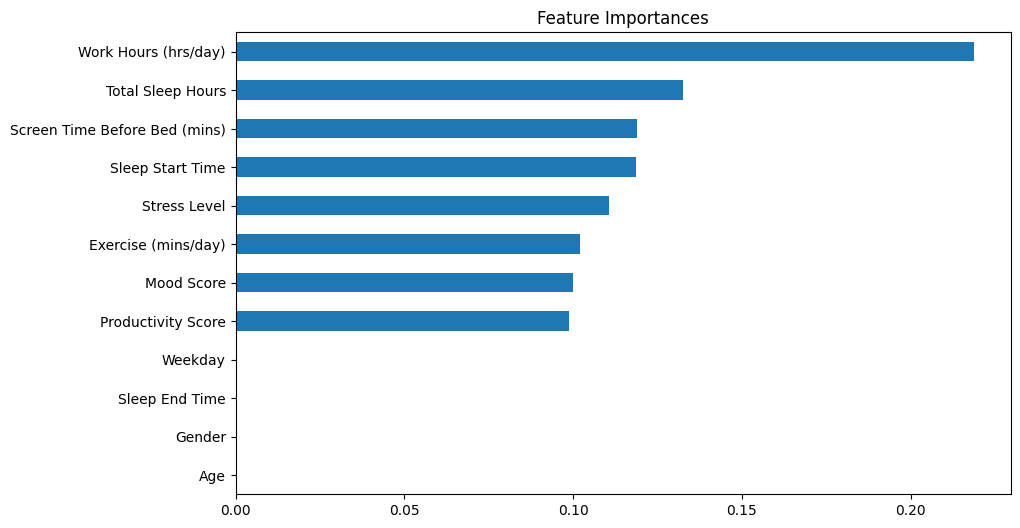

In [13]:
importance = pd.Series(tree_full.feature_importances_, index=X.columns)
importance.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title('Feature Importances')
plt.show()

의사결정나무 기법을 사용하여 중요도가 큰 변수를 순서대로 정렬한 중요도 그래프이다. 중요도가 높은 변수를 적절한 개수로 선택하여 축소모형을 모델링하고자 한다. 중요도가 가장 높은 변수는 'Work Hours(hrs/day)', 'Total Sleep Hours', 'Screen Time Before Bed (mins)', 'Sleep Start Time', 'Stress Level''Exercise (mins/day)',
 'Mood Score'순인 것을 확인할 수 있고, 상위 7개의 변수로 만든 축소모형과 전체모형을 비교하여 최종모형을 결정한다. 

In [14]:
importances.head(7).index.tolist()

['Work Hours (hrs/day)',
 'Total Sleep Hours',
 'Screen Time Before Bed (mins)',
 'Sleep Start Time',
 'Stress Level',
 'Exercise (mins/day)',
 'Mood Score']

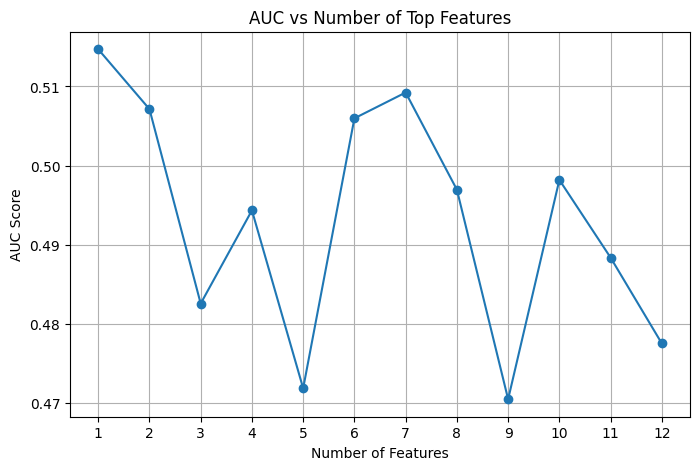

In [15]:
# AUC 계산용 함수
def evaluate_auc_by_feature_count(X_train, X_test, y_train, y_test, importances, max_features=10):
    auc_scores = []

    sorted_features = importances.sort_values(ascending=False)
    feature_list = sorted_features.index.tolist()

    for i in range(1, max_features + 1):
        selected_features = feature_list[:i]
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train_subset, y_train)
        prob = model.predict_proba(X_test_subset)[:, 1]
        auc = roc_auc_score(y_test, prob)
        auc_scores.append((i, auc))

    return pd.DataFrame(auc_scores, columns=["num_features", "AUC"])

# 결과 시각화
def plot_auc(df):
    plt.figure(figsize=(8,5))
    plt.plot(df["num_features"], df["AUC"], marker='o')
    plt.title("AUC vs Number of Top Features")
    plt.xlabel("Number of Features")
    plt.ylabel("AUC Score")
    plt.grid()
    plt.xticks(df["num_features"])
    plt.show()


auc_df = evaluate_auc_by_feature_count(X_train, X_test, y_train, y_test, importance, max_features=12)
plot_auc(auc_df)


변수 중요도 기반으로 1 ~ 12개의 상위 변수를 순차적으로 포함하여 AUC 변화를 분석한 결과, 변수 개수가 1개일 때 AUC 값이 약 0.515로 가장 높았다. 이후 6개, 7개, 10개일 때에도 비교적 안정적인 AUC 성능을 보였으나, 변수 5개를 사용했을 때는 오히려 AUC가 약 0.47로 가장 낮은 결과를 나타냈다.
따라서 임의로 상위 5개의 변수만 사용하는 것보다는, 오히려 1개 또는 6~7개 수준의 변수 조합이 더 높은 예측 성능을 나타낼 수 있음이 확인되었다. 특히 단일 변수만으로도 간단한 구조로 예측 성능을 확보할 수 있으므로, 목적에 따라 설명력 vs. 단순성 중 균형을 고려한 변수 개수 선택이 요구된다.

In [16]:
#축소모형 학습
top_features = importances.head(7).index.tolist()
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

tree_reduced = DecisionTreeClassifier(
    max_depth=5,                
    min_samples_split=30,      
    max_leaf_nodes=10,         
    random_state=0)
tree_reduced.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, min_samples_split=30,
                       random_state=0)

In [17]:
y_test_pred_reduced = tree_reduced.predict(X_test_reduced)
y_test_prob_reduced = tree_reduced.predict_proba(X_test_reduced)[:, 1]


#평가지표
print(classification_report(y_test, y_test_pred_reduced))
print("AUC:", roc_auc_score(y_test, y_test_prob_reduced))


              precision    recall  f1-score   support

           0       0.35      0.03      0.05       382
           1       0.62      0.97      0.75       618

    accuracy                           0.61      1000
   macro avg       0.49      0.50      0.40      1000
weighted avg       0.52      0.61      0.49      1000

AUC: 0.5024674257442518


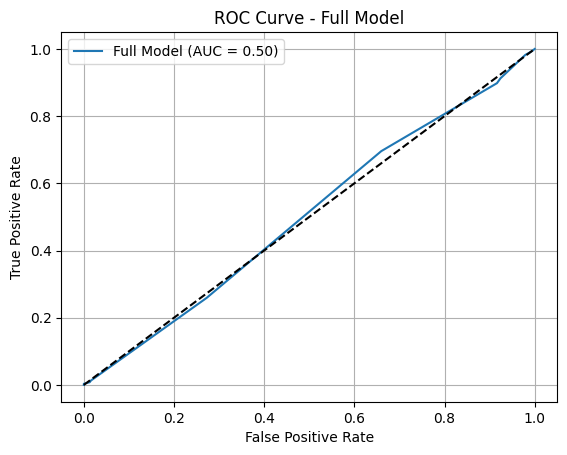

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_full)

plt.figure()
plt.plot(fpr, tpr, label='Full Model (AUC = %.2f)' % roc_auc_score(y_test, y_test_prob_full))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Full Model")
plt.legend()
plt.grid()
plt.show()


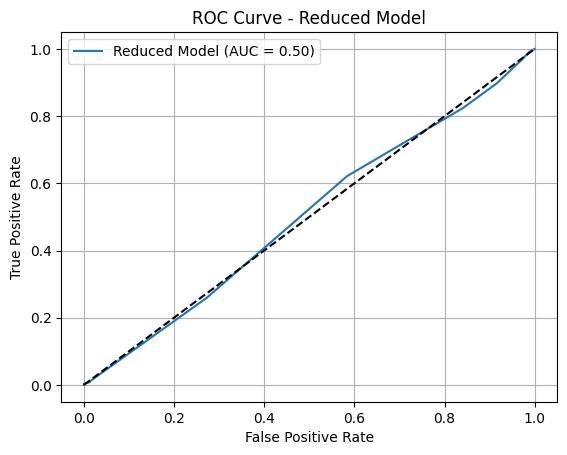

In [19]:
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_test_prob_reduced)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr_reduced, tpr_reduced, label='Reduced Model (AUC = %.2f)' % roc_auc_score(y_test, y_test_prob_reduced))
plt.plot([0, 1], [0, 1], 'k--')  # 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Reduced Model")
plt.legend()
plt.grid()
plt.show()

전체모형과 축소모형의 ROC곡선이다. 전체모형의 AUC는 0.504, 축소모형의 AUC는 0.502로, 성능 차이는 매우 미미하였다.
복잡한 전체모형은 해석에 어려움이 있을 수 있으며, 변수 수가 많을수록 모델의 일반화 가능성에도 불리할 수 있다. 반면, 축소모형은 비슷한 예측력을 유지하면서도 트리 구조가 간결하여 모델 해석과 설명이 용이하다는 장점이 있다.
이에 따라 본 연구에서는 축소모형을 최종 의사결정나무 모델로 채택하였다.

In [20]:
conf_matrix = confusion_matrix(y_test, y_test_pred_full)

# 보기 좋게 데이터프레임으로 출력
pd.DataFrame(conf_matrix, 
             index=['실제 0', '실제 1'], 
             columns=['예측 0', '예측 1'])

,예측 0,예측 1
실제 0,8,374
실제 1,11,607


In [21]:
conf_matrix = confusion_matrix(y_test, y_test_pred_reduced)

# 보기 좋게 데이터프레임으로 출력
pd.DataFrame(conf_matrix, 
             index=['실제 0', '실제 1'], 
             columns=['예측 0', '예측 1'])

,예측 0,예측 1
실제 0,11,371
실제 1,20,598


위 표는 의사결정나무의 전체모형과 축소모형의 혼동행렬을 나타낸 것이다. 이를 기반으로 전체모형과 축소모형의 성능을 비교하였다. 
전체모형에서는 실제 수면의 질이 낮은 집단(실제값 0)에 대해 8건을 정확히 예측하고 374건을 잘못 예측하였으며, 수면의 질이 높은 집단(실제값 1)은 607건을 정확히 예측하고 11건을 잘못 분류하였다. 축소모형은 수면의 질이 낮은 집단에 대해 11건을 정확히 예측하고 371건을 오분류하였으며, 수면의 질이 높은 집단은 598건을 정확히 예측하고 20건을 잘못 분류하였다.

두 모형 모두 수면의 질이 높은 집단에 비해 낮은 집단의 분류 성능이 떨어지는 경향을 보였으며, 전체모형의 긍정(질 높음) 예측 정확도는 98.22%, 부정(질 낮음) 예측 정확도는 2.10%였고, 축소모형의 긍정 예측 정확도는 96.75%, 부정 예측 정확도는 2.88%였다.
즉, 두 모델 간 AUC 및 분류 성능 차이는 미미하며, 오히려 축소모형이 부정 예측에서 더 나은 성능을 보였다.
이러한 결과를 바탕으로, 해석 용이성과 모델 단순성, 그리고 변수 수 절감에도 불구하고 유지된 유사한 성능을 고려하여 축소모형을 최종 의사결정나무 모형으로 선정하였다. 특히, 수면의 질이 낮은 집단에 대한 구분이 중요한 경우 축소모형이 실용적인 선택이 될 수 있다.

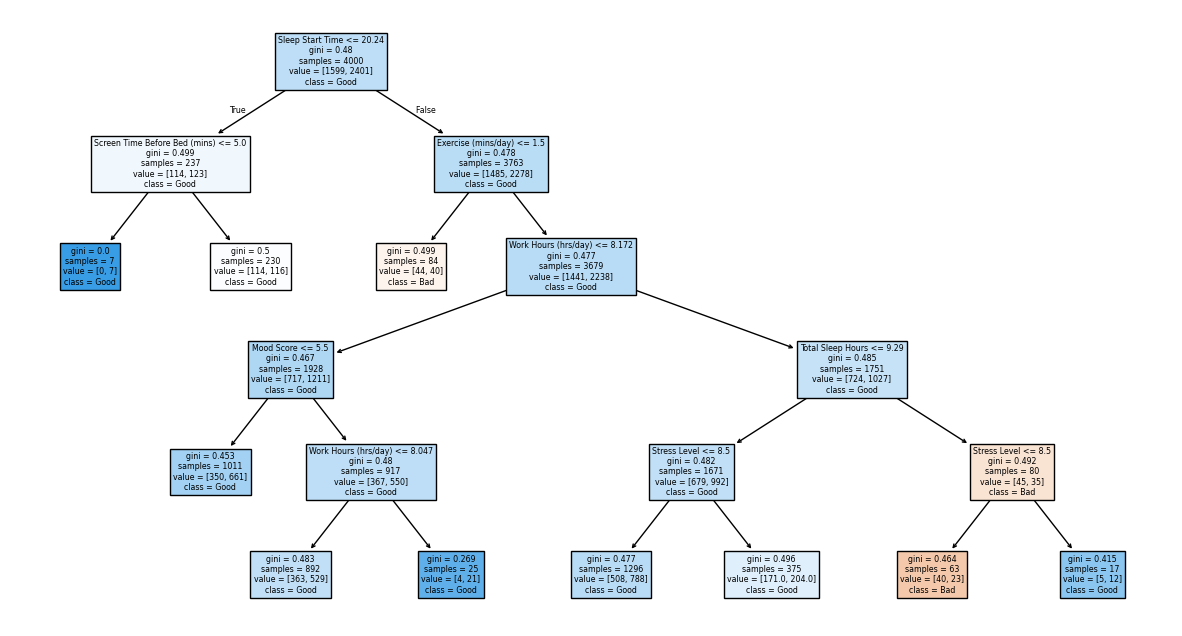

In [22]:
plt.figure(figsize=(15, 8))
tree.plot_tree(
    tree_reduced,
    feature_names=top_features,  
    class_names=['Bad', 'Good'],
    filled=True
)
plt.show()


축소모형의 의사결정나무를 시각화한 것이다. 뿌리 노드는 ‘Sleep Start Time(수면 시작 시각)’으로, 24시 이전에 잠드는 경우(left)와 이후에 잠드는 경우(right)로 데이터를 분기한다. 수면 시작 시각이 24시 이하인 경우, 대부분이 수면의 질이 높은 집단(Good)으로 분류되었고, 이후 ‘Screen Time Before Bed(취침 전 스크린 사용시간)’과 ‘Mood Score’ 등의 변수에 따라 추가적인 분류가 이루어진다.

반면, 24시 이후에 잠드는 경우에는 ‘Exercise Time(운동 시간)’과 ‘Work Hours(일일 근무 시간)’, ‘Total Sleep Hours(총 수면 시간)’ 등의 조건에 따라 수면의 질이 높은 집단과 낮은 집단으로 분류된다. 예를 들어, ‘운동 시간이 1.5분 이하’이고 ‘Work Hours가 8.17시간 이하’인 경우는 수면의 질이 낮은 집단으로 분류되는 경향이 있었다. 반대로, 운동 시간과 총 수면 시간이 충분하고 스트레스 수준이 낮을수록 수면의 질이 높은 집단으로 분류되는 패턴이 관찰되었다.
